<a href="https://colab.research.google.com/github/TSKsteff/Classificacao_De_Imagens/blob/main/CNN_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

Exemplo retirado do site da Tensorflow e Keras

Este tutorial demonstra o treinamento de uma [Rede Neural Convolucional](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) simples para classificar [imagens CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html). Como este tutorial usa a [API Sequencial Keras](https://www.tensorflow.org/guide/keras/overview), criar e treinar seu modelo levará apenas algumas linhas de código.



### Import TensorFlow

In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

### Baixe e prepare o conjunto de dados CIFAR10


O conjunto de dados CIFAR10 contém 60.000 imagens coloridas em 10 classes, com 6.000 imagens em cada classe. O conjunto de dados é dividido em 50.000 imagens de treinamento e 10.000 imagens de teste. As classes são mutuamente exclusivas e não há sobreposição entre elas.

In [4]:
import os
HOME_DIR = os.getcwd()
print(HOME_DIR)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

HOME_DIR = '/content/gdrive/MyDrive/Colab Notebooks'
os.chdir(os.path.join(HOME_DIR, "dataset"))

!pwd
dataset_dir = '/content/gdrive/MyDrive/Colab Notebooks/dataset'

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

/content
Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/dataset


In [6]:
def load_processed_data(data_dir):
    images = []
    labels = []
    for label in ['Positive', 'Negative']:
        label_dir = os.path.join(data_dir, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                img = cv2.imread(os.path.join(label_dir, filename))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Carregar dados processados
train_image_processed, train_labels_processed = load_processed_data(train_dir)
test_image_processed, test_labels_processed = load_processed_data(test_dir)

print("Train:", train_image_processed.shape, train_labels_processed.shape)
print("Test:", test_image_processed.shape, test_labels_processed.shape)

Train: (32000, 64, 64, 3) (32000,)
Test: (8000, 64, 64, 3) (8000,)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(train_image_processed[i], cv2.COLOR_BGR2RGB))
    plt.title(f'Original: {train_labels_processed[i]}')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(cv2.cvtColor(test_image_processed[i], cv2.COLOR_BGR2RGB))
    plt.title(f'Processed: {test_labels_processed[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Verifique os dados

Para verificar se o conjunto de dados está correto, vamos traçar as primeiras 25 imagens do conjunto de treinamento e exibir o nome da classe abaixo de cada imagem:


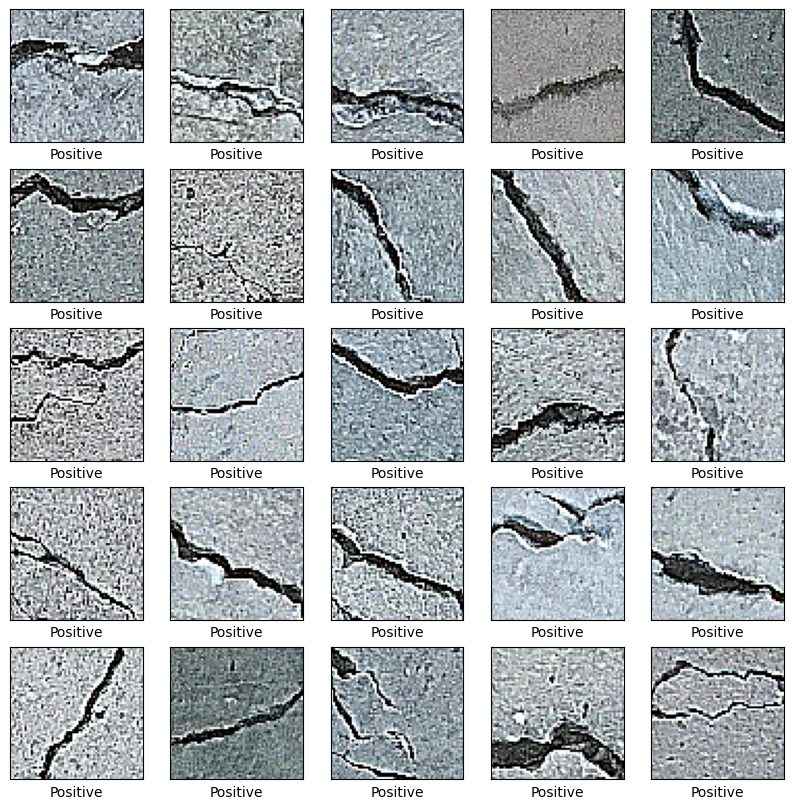

In [7]:
class_names = ['Positive', 'Negative']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image_processed[i])
    plt.xlabel(train_labels_processed[i])
plt.show()

### Crie a base convolucional

As 6 linhas de código abaixo definem a base convolucional usando um padrão comum: uma pilha de [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) e [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) camadas.

Como entrada, uma CNN recebe tensores de forma (image_height, image_width, color_channels), ignorando o tamanho do lote. Se você é novo nessas dimensões, color_channels refere-se a (R,G,B). Neste exemplo, você configurará sua CNN para processar entradas de formato (32, 32, 3), que é o formato das imagens CIFAR. Você pode fazer isso passando o argumento `input_shape` para sua primeira camada.


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Vamos exibir a arquitetura do seu modelo até agora:

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Acima, você pode ver que a saída de cada camada Conv2D e MaxPooling2D é um tensor 3D de forma (altura, largura, canais). As dimensões de largura e altura tendem a encolher à medida que você se aprofunda na rede. O número de canais de saída para cada camada Conv2D é controlado pelo primeiro argumento (por exemplo, 32 ou 64). Normalmente, à medida que a largura e a altura diminuem, você pode permitir (computacionalmente) adicionar mais canais de saída em cada camada Conv2D.

### Adicione camadas densas no topo

Para completar o modelo, você alimentará o último tensor de saída da base convolucional (da forma (4, 4, 64)) em uma ou mais camadas densas para realizar a classificação. As camadas densas recebem vetores como entrada (que são 1D), enquanto a saída atual é um tensor 3D. Primeiro, você achatará (ou desenrolará) a saída 3D para 1D e, em seguida, adicionará uma ou mais camadas densas no topo. CIFAR tem 10 classes de saída, então você usa uma camada densa final com 10 saídas.

In [10]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Aqui está a arquitetura completa do seu modelo:

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,858 (2.47 MB)

 Trainable params: 646,858 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

O resumo da rede mostra que (4, 4, 64) as saídas foram achatadas em vetores de forma (1024) antes de passar por duas camadas densas.

### Compile and train the model

In [12]:
train_image_processed, validation_image, train_labels_processed, validation_labels = train_test_split(train_image_processed, train_labels_processed, test_size=0.2, random_state=42)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
train_labels_processed = np.where(train_labels_processed == 'positive', 1, 0)
validation_labels = np.where(validation_labels == 'positive', 1, 0)
history = model.fit(train_image_processed, train_labels_processed, epochs=10,
                    validation_data=(validation_image, validation_labels))

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9909 - loss: 0.1832 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

### Avalie o modelo

250/250 - 1s - 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00


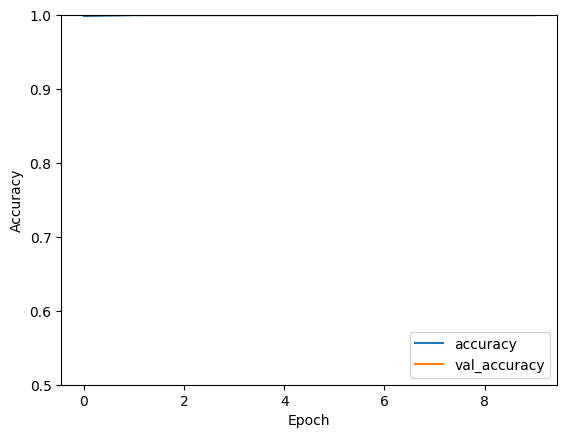

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_labels_processed = np.where(test_labels_processed == 'positive', 1, 0)
test_loss, test_acc = model.evaluate(test_image_processed,  test_labels_processed, verbose=2)

In [15]:
print(test_acc)

1.0


Sua CNN simples alcançou uma precisão de teste de mais de 70%. Nada mal para algumas linhas de código! Para outro estilo de CNN, confira o exemplo de [início rápido do TensorFlow 2 para especialistas](https://www.tensorflow.org/tutorials/quickstart/advanced) que usa a API de subclasse Keras e `tf.GradientTape`.

## Testa o modelo imagem por imagem

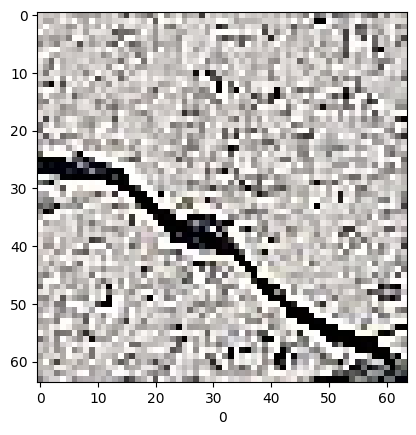

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
[[ 9586.367  -4509.96    1651.83    -287.187  -1537.3369  3827.304
  -1907.51   -1741.3173  3512.6646  -573.3435]]


In [18]:
import numpy as np
num_image = 1
plt.imshow(cv2.cvtColor(test_image_processed[num_image], cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for displaying
plt.xlabel(test_labels_processed[num_image])
plt.show()
image2test = test_image_processed[num_image]
image2test = image2test.reshape((1, 64, 64, 3)) # Reshape to (1, 64, 64, 3) to match the model's input shape
print(model.predict(image2test))
#['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
#     0            1           2      3       4     5       6        7       8       9